# Anomaly Detection: Knowledge Distillation

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import sys

from tqdm.notebook import trange
from sklearn.metrics import roc_curve, auc

## Training the Oracle: LeNet5 Classifier

In [2]:
train_dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('./data/', train=True, download=False,
                                         transform=transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                     (0.2023, 0.1994, 0.2010))
                ])),
  batch_size=256, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('./data/', train=False, download=False,
                             transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                     (0.2023, 0.1994, 0.2010))
                ])),
  batch_size=1, shuffle=False)

In [5]:
class LeNet5(torch.nn.Module):
    def __init__(self, num_classes, batch_norm=False):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.fc1   = nn.Linear(400, 120)
        self.relu3 = nn.ReLU()
        self.fc2   = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3   = nn.Linear(84, num_classes)
        
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        if batch_norm:
            self.bn1 = nn.BatchNorm2d(6)
            self.bn2 = nn.BatchNorm2d(16)
            self.bn3 = nn.BatchNorm1d(120)
            self.bn4 = nn.BatchNorm1d(84)
        else:
            self.bn1 = nn.Identity()
            self.bn2 = nn.Identity()
            self.bn3 = nn.Identity()
            self.bn4 = nn.Identity()

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.pool1(out)
        out = self.relu2(self.bn2(self.conv2(out)))
        out = self.pool2(out)
        out = out.reshape(out.shape[0], -1)
        out = self.relu3(self.bn3(self.fc1(out)))
        out = self.relu4(self.bn4(self.fc2(out)))
        out = self.fc3(out)
        return out

oracle = LeNet5(10, True).to(0)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(oracle.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)
epochs = 60

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':1.5f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{avg' + self.fmt + '} ({name})'
        return fmtstr.format(**self.__dict__)

In [8]:
acc, loss = AverageMeter('Accuracy'), AverageMeter('Loss')

# Iterate over the dataset <epochs> times
for epoch in range(epochs):

    # Set the model to training mode
    oracle.train()
    
    # Reset our meters
    acc.reset()
    loss.reset()

    # This is just here because it's pretty 
    tr = trange(len(train_dataloader), file=sys.stdout)

    # Iterate over batches
    for inputs, targets in train_dataloader:
        
        inputs, targets = inputs.to(0), targets.to(0)
        
        # Remove previous gradients
        optimizer.zero_grad()
        
        # Feed forward the input
        outputs = oracle(inputs)

        # Compute the loss and accuracy
        loss_batch = criterion(outputs, targets)
        
        # Compute the gradients
        loss_batch.backward()

        # Update parameters
        optimizer.step()      

        preds = torch.argmax(outputs, dim=-1)
        accuracy = (targets == preds).sum() / len(targets)
        acc.update(accuracy.data)
        loss.update(loss_batch.data)

        # Show the current results
        tr.set_description('Epoch {}, {}, {}'.format(epoch+1, loss, acc))
        tr.update(1)

In [9]:
# Get the anomaly scores

losses = []

oracle.eval()
for inputs, targets in test_dataloader:
    inputs, targets = inputs.to(0), targets.to(0)
    outputs = oracle(inputs)
    loss = criterion(outputs, targets)
    losses.append(loss.item())

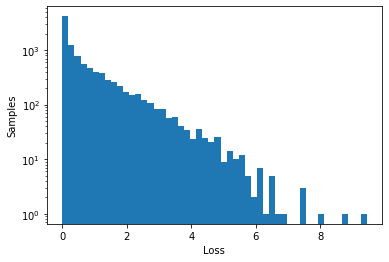

In [10]:
# Check the loss distibution

plt.hist(losses, bins=50)
plt.xlabel("Loss")
plt.ylabel("Samples")
plt.semilogy();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

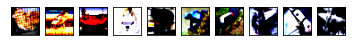

In [11]:
# Plot the most anomlaous samples

cut = sorted(losses)[-10]
figure1, axis1 = plt.subplots(1, 10)
i = 0
for inputs, targets in test_dataloader:
    inputs, targets = inputs.to(0), targets.to(0)
    outputs = oracle(inputs)
    loss = criterion(outputs, targets)
    if loss >= cut:
        axis1[i].get_xaxis().set_visible(False)
        axis1[i].get_yaxis().set_visible(False)
        axis1[i].imshow(np.transpose(inputs.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        i += 1

## Teacher Network: Autoencoder

In [20]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2,padding=1),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [21]:
ae = Autoencoder().to(0)

In [22]:
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(ae.parameters())

In [23]:
loss = AverageMeter('Loss')

# Iterate over the dataset <epochs> times
for epoch in range(epochs):

    # Set the model to training mode
    ae.train()
    
    # Reset our meters
    loss.reset()

    # This is just here because it's pretty 
    tr = trange(len(train_dataloader), file=sys.stdout)

    # Iterate over batches
    for inputs, _ in train_dataloader:
        
        inputs = inputs.to(0)
        
        # Remove previous gradients
        optimizer_ae.zero_grad()
        
        # Feed forward the input
        outputs = ae(inputs)

        # Compute the loss and accuracy
        loss_batch = criterion_ae(outputs, inputs)
        
        # Compute the gradients
        loss_batch.backward()

        # Update parameters
        optimizer_ae.step()

        # Show the current results
        loss.update(loss_batch.data)
        tr.set_description('Epoch {}, {}'.format(epoch+1, loss))
        tr.update(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

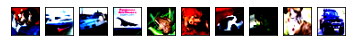

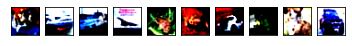

In [36]:
# Plot some reconstruction examples

figure1, axis1 = plt.subplots(1, 10)
figure2, axis2 = plt.subplots(1, 10)
i = 0
for i, (inputs, _) in enumerate(test_dataloader):
    inputs = inputs.to(0)
    outputs = ae(inputs)

    axis1[i].get_xaxis().set_visible(False)
    axis1[i].get_yaxis().set_visible(False)
    axis1[i].imshow(np.transpose(inputs.squeeze().detach().cpu().numpy(), (1, 2, 0)))
    
    axis2[i].get_xaxis().set_visible(False)
    axis2[i].get_yaxis().set_visible(False)
    axis2[i].imshow(np.transpose(outputs.squeeze().detach().cpu().numpy(), (1, 2, 0)))

    if i == 9:
        break

In [25]:
# Get the teacher scores

ae.eval()

scores = []
for inputs, _ in test_dataloader:
    inputs = inputs.to(0)
    outputs = ae(inputs)
    loss = criterion_ae(outputs, inputs)
    scores.append(loss.item())

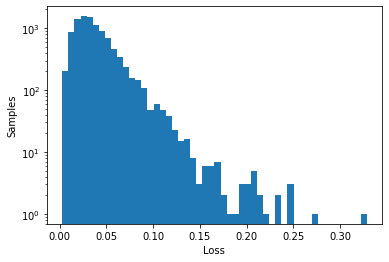

In [26]:
# Check the score distibution

plt.hist(scores, bins=50)
plt.xlabel("Loss")
plt.ylabel("Samples")
plt.semilogy();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

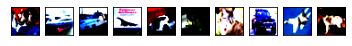

In [37]:
# Plot the most anomlaous samples according to the Teacher

cut = sorted(scores)[-10]
figure1, axis1 = plt.subplots(1, 10)
i = 0
for inputs, targets in test_dataloader:
    inputs, targets = inputs.to(0), targets.to(0)
    outputs = oracle(inputs)
    loss = criterion(outputs, targets)
    if loss >= cut:
        axis1[i].get_xaxis().set_visible(False)
        axis1[i].get_yaxis().set_visible(False)
        axis1[i].imshow(np.transpose(inputs.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        i += 1
    if i == 10: 
        break

In [38]:
from sklearn.metrics import roc_curve, auc

ANOMALY_THRESHOLD = 3

fpr, tpr, _ = roc_curve(0 + (np.array(losses) > ANOMALY_THRESHOLD), scores)
auc(fpr, tpr)

0.5365559346767098

## Student: Shallow Network

In [39]:
import torch.nn as nn
import torch.nn.functional as F

class Shallow(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*32*32, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

student = Shallow().to(0)

In [40]:
criterion_student = nn.MSELoss()
criterion_teacher = nn.MSELoss(reduction='none')
optimizer_student = optim.Adam(student.parameters(), lr=0.01)

In [41]:
loss = AverageMeter('Loss')

# Iterate over the dataset <epochs> times
for epoch in range(epochs):

    # Set the model to training mode
    student.train()
    
    # Reset our meters
    loss.reset()

    # This is just here because it's pretty 
    tr = trange(len(train_dataloader), file=sys.stdout)

    # Iterate over batches
    for inputs, _ in train_dataloader:
        
        inputs = inputs.to(0)
        
        # Remove previous gradients
        optimizer_student.zero_grad()
        
        # Feed forward the input
        outputs = student(inputs)
        
        outputs_teacher = ae(inputs)
        loss_teacher = criterion_teacher(outputs_teacher, inputs).mean(-1).mean(-1) * 100

        # Compute the loss and accuracy
        loss_batch = criterion_student(outputs, loss_teacher)
        
        # Compute the gradients
        loss_batch.backward()

        # Update parameters
        optimizer_student.step()

        # Show the current results
        loss.update(loss_batch.data)
        tr.set_description('Epoch {}, {}'.format(epoch+1, loss))
        tr.update(1)

/afs/cern.ch/work/a/adpol/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([256, 3])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/afs/cern.ch/work/a/adpol/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([80, 3])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [42]:
# Get the students scores

student.eval()

scores_student = []
for inputs, _ in test_dataloader:
    inputs = inputs.to(0)
    outputs = student(inputs)
    scores_student.append(outputs.item())

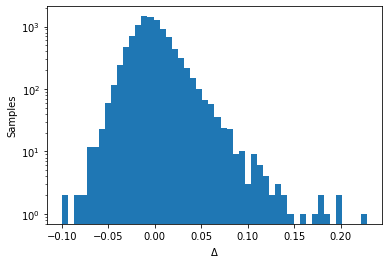

In [43]:
# Check the delta distibution

plt.hist(np.array(scores)-np.array(scores_student)/100, bins=50)
plt.xlabel("$\Delta$")
plt.ylabel("Samples")
plt.semilogy();

In [44]:
teacher_aucs = []
student_aucs = []
cuts = []

for ANOMALY_THRESHOLD in sorted(np.array(losses))[::10]:
    fpr, tpr, _ = roc_curve(0 + (np.array(losses) > ANOMALY_THRESHOLD), scores)
    teacher_aucs.append(auc(fpr, tpr))

    fpr, tpr, _ = roc_curve(0 + (np.array(losses) > ANOMALY_THRESHOLD), scores_student)
    student_aucs.append(auc(fpr, tpr))
    
    cuts.append(ANOMALY_THRESHOLD)

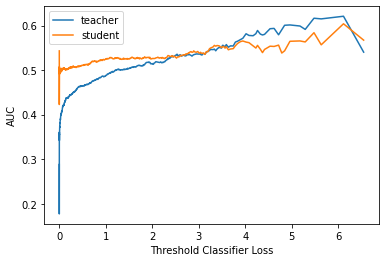

In [45]:
plt.plot(cuts, teacher_aucs, label='teacher')
plt.plot(cuts, student_aucs, label='student')
plt.ylabel("AUC")
plt.xlabel("Threshold Classifier Loss")
plt.legend()
plt.show();